## Retentostat regression model

Based on the regression model from [Rebnegger et al, 2016](https://doi.org/10.1128/AEM.00638-16). Model was ported to Python and some modifiications made to include a non-linear fit the $q_P$ to $\mu$ relationship. The actual model is in RegressionFuncs.py. Further modifications were made to the model in [Coltman et al, 2023](), and the functions to fit the model are shared, allowing easier comparisons.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FormatStrFormatter

import os

from RegressionFuncs import *

os.makedirs("../results/Rebnegger2023", exist_ok=True)

Parameter 0: 3.6399e-03 ± 3.4e-05
Parameter 1: 6.4235e-05 ± 2.1e-05


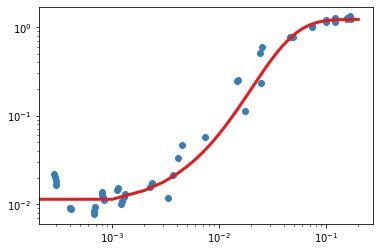

Parameter 0: 3.7790e-03 ± 1.6e-06
Parameter 1: 6.4965e-05 ± 1.0e-06


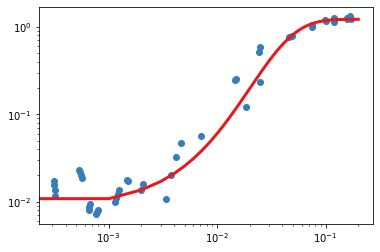

Parameter 0: 3.5578e-03 ± 3.1e-04
Parameter 1: 1.4535e-04 ± 9.6e-05


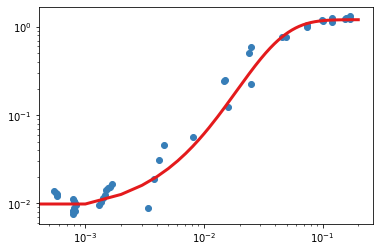

In [2]:
# Set maximum yield of product on substrate
max_yield_p_substrate = 0.609
# Set maximum yield coefficient for biomass on substrate
max_yield_x_substrate = 0.54

# Containers for results
all_results = []
all_sample_point_results = []
all_statistics = []

# Read data from Excel file
filename = 'AllRetentostatData.xlsx'
for sheet_name in ["C023", "C024", "C030"]:
    
    # Load culture data from the sheet
    culture_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:13, 1:8]
    culture_data.columns = culture_data.iloc[0]
    culture_data.drop(index=1, inplace=True)
    
    # Extract relevant columns and convert to numpy arrays
    time_lab_d, viable_cell_conc, viable_cell_conc_std_v, dry_weight, dry_weight_std, time_csin, substrate_conc_lab = [
        x.reshape(-1, 1).astype(np.float64) for x in culture_data.T.values
    ]
    
    # Adjust standard deviations where necessary
    low_std_mask = dry_weight_std < 1e-2
    dry_weight_std[low_std_mask] = dry_weight[low_std_mask] * 0.01
    viable_cell_conc_std_v[low_std_mask] = dry_weight_std[low_std_mask] * (viable_cell_conc[low_std_mask] / dry_weight[low_std_mask])
    
    # Calculate viability
    viability = viable_cell_conc / dry_weight
    time_lab_h = round_to_half(24 * time_lab_d)
    
    # Load reactor configuration data
    reactor_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:4, 9:]
    reactor_data.columns = ["Parameter", "Value", "Description"]
    reactor_data.set_index("Parameter", inplace=True)
    volume_a, volume_b, inlet_flow_rate_a = [np.array([[x]]) for x in reactor_data["Value"]]
    inlet_flow_rate_a = inlet_flow_rate_a / 1000  # Convert to correct units

    # Load productivity data
    productivity_data_all = pd.read_excel(f"../data/qp_Cp_Retentostat_Chemostat.xlsx", 
                                      sheet_name=sheet_name, usecols="A:P", nrows=29)
    productivity_interpolated_time_h = productivity_data_all["time (h)"].values.flatten()
    
    productivity_data_measured = productivity_data_all[~productivity_data_all["Sample Point"].isna()]
    protein_conc = productivity_data_measured["CP measured (mg/L)"].values.reshape(-1,1)
    
    chemostat_data = pd.read_excel(f"../data/qp_Cp_Retentostat_Chemostat.xlsx", sheet_name="Chemostats")
    chemostat_mu = chemostat_data["mu (h-1)"].values
    chemostat_qp = chemostat_data["qP (g/g.h)"].values

    # Concatenate data from retentostat and chemostat experiments
    all_mu = np.concatenate([productivity_data_all["mu piecewise (h-1)"].values, chemostat_mu])
    all_qp = np.concatenate([productivity_data_all["qP (mg/g.h)"].values / 1000, chemostat_qp])  # Convert to consistent units
    
    # Fit Gompertz function to the concatenated data
    sigma = all_qp * 0.01
    gompertz_bounds = (0, np.inf)
    gompertz_params, pcov = curve_fit(
        gompertz_function, all_mu, all_qp,
        p0=[1.5 * max(all_qp), 1, max(all_qp) / 10],
        sigma=sigma, bounds=gompertz_bounds, ftol=1e-9
    )
    
    production_func = gompertz_function
    death_func = False
    # Perform regression analysis
    regression_results, statistics_series = retentostat_regression(
        time_csin, substrate_conc_lab, inlet_flow_rate_a, volume_a, volume_b,
        viable_cell_conc, time_lab_h, viable_cell_conc_std_v, dry_weight, dry_weight_std,
        protein_conc, max_yield_x_substrate, max_yield_p_substrate, production_func, death_func, gompertz_params
    )
    
    # Append results to the lists
    regression_results = regression_results.assign(Cultivation=sheet_name, Fit="Gompertz")
    all_results.append(regression_results)
    
    statistics_series.name = ("Gompertz", sheet_name)
    all_statistics.append(statistics_series)

    # Process sample point results
    sample_point_result = regression_results.loc[regression_results["Time h"].isin(time_lab_h.flatten())].copy()
    sample_point_result["Sample Point"] = [f"R{i}" for i in range(11)]
    sample_point_result.at[0, "Sample Point"] = "SS"
    all_sample_point_results.append(sample_point_result)

    # Plot fitted Gompertz function and data points
    mu_plot = np.linspace(0, 0.2, 200)
    plt.rcParams.update({'mathtext.default': 'regular'})
    fig, ax = plt.subplots()
    ax.plot(mu_plot, 1000 * gompertz_function(mu_plot, *gompertz_params), label="Fitted Gompertz", c="#e41a1c", lw=3)
    ax.scatter(all_mu, 1000 * all_qp, label="Data Points", c="#377eb8")
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.show()

# Save the compiled results to CSV files
all_statistics = pd.concat(all_statistics, axis=1).T.sort_index()
all_statistics.index = all_statistics.index.set_names(['Fit', 'Cultivation'])
all_statistics.to_csv("../results/Rebnegger2023/StatsRetentostat.csv")
all_results = pd.concat(all_results).set_index(["Fit", "Cultivation"])
all_results["Interpolated/Pirt"] = all_results["Growth Rate model 1/h"]/all_results["Growth Rate Pirt 1/h"]
all_results.to_csv("../results/Rebnegger2023/RegressionRetentostat.csv")
pd.concat(all_sample_point_results).set_index(["Fit", "Cultivation"]).to_csv("../results/Rebnegger2023/SamplePointsDynamicRetentostat.csv")

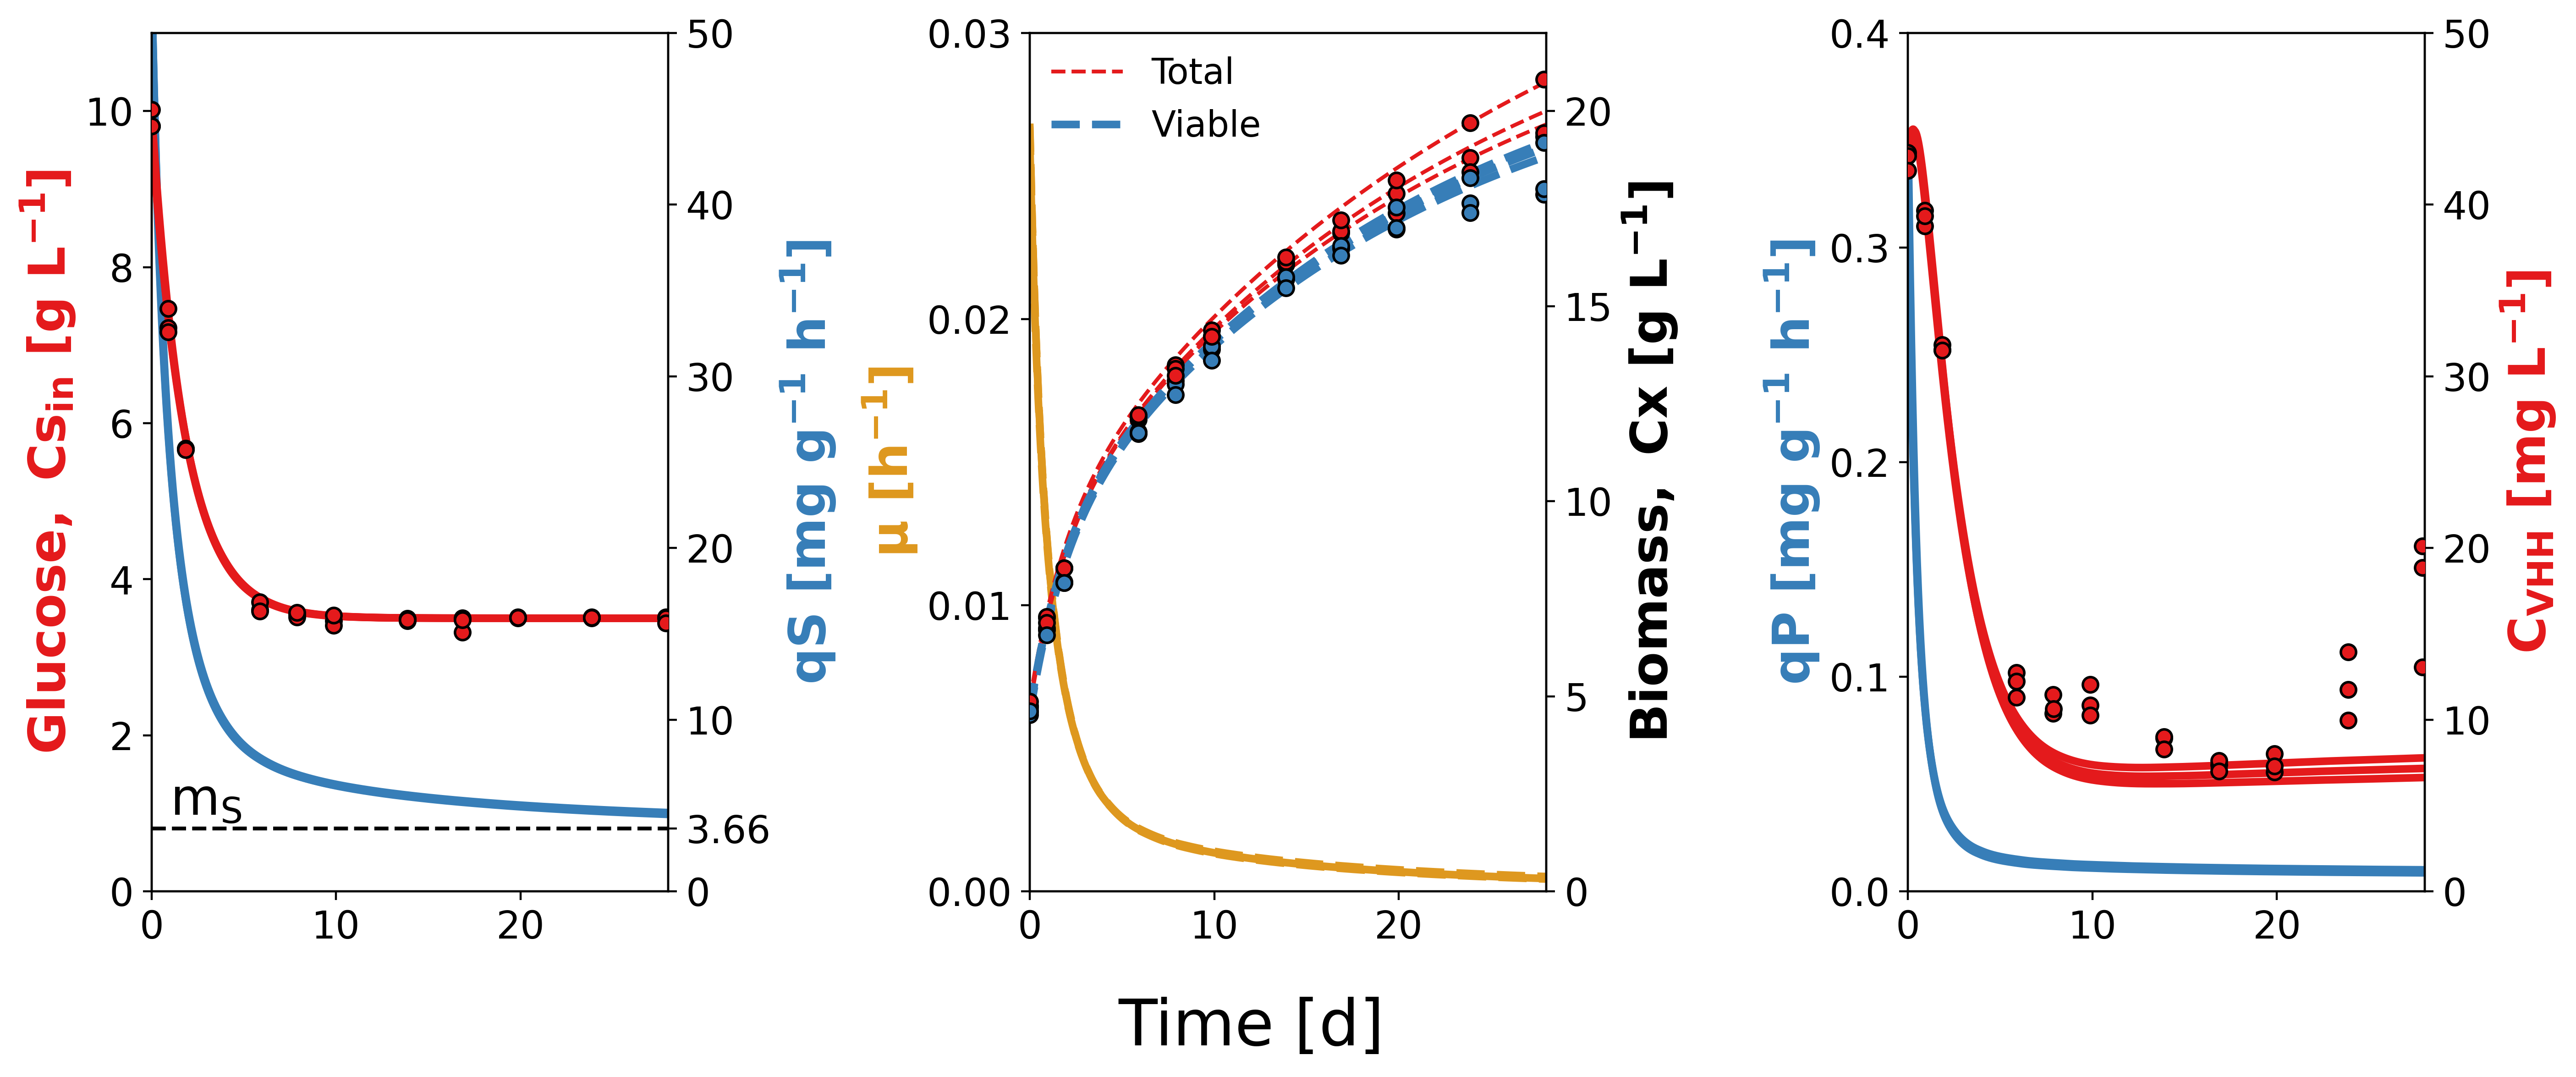

In [3]:
filename = 'AllRetentostatData.xlsx'#;

for model_type in all_results.index.get_level_values("Fit").unique():
    fig = plt.figure(figsize=(16, 6), dpi=400)
    spec = fig.add_gridspec(1, 1, wspace=0.8, bottom=0.1)

    gssub = spec[0].subgridspec(1, 3)
    ax1 = fig.add_subplot(gssub[0, 0])
    ax2 = ax1.twinx()
    ax3 = fig.add_subplot(gssub[0, 1])
    ax4 = ax3.twinx()
    ax5 = fig.add_subplot(gssub[0, 2])
    ax6 = ax5.twinx()

    fig.text(0.5, -0.04, 'Time [d]', ha='center', fontsize=25)

    temp = all_results.loc[model_type]
    for sheet_name in temp.index.unique():
        # Load culture data from the sheet
        culture_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:13, 1:8]
        culture_data.columns = culture_data.iloc[0]
        culture_data.drop(index=1, inplace=True)

        # Extract relevant columns and convert to numpy arrays
        time_lab_d, viable_cell_conc, viable_cell_conc_std_v, dry_weight, dry_weight_std, time_csin, substrate_conc_lab = [
            x.reshape(-1, 1).astype(np.float64) for x in culture_data.T.values
        ]

        # Adjust standard deviations where necessary
        low_std_mask = dry_weight_std < 1e-2
        dry_weight_std[low_std_mask] = dry_weight[low_std_mask] * 0.01
        viable_cell_conc_std_v[low_std_mask] = dry_weight_std[low_std_mask] * (viable_cell_conc[low_std_mask] / dry_weight[low_std_mask])

        # Calculate viability
        viability = viable_cell_conc / dry_weight
        time_lab_h = round_to_half(24 * time_lab_d)
        
        # Load reactor configuration data
        reactor_data = pd.read_excel(f"../data/{filename}", sheet_name=sheet_name).iloc[1:4, 9:]
        reactor_data.columns = ["Parameter", "Value", "Description"]
        reactor_data.set_index("Parameter", inplace=True)
        volume_a, volume_b, inlet_flow_rate_a = [np.array([[x]]) for x in reactor_data["Value"]]
        inlet_flow_rate_a = inlet_flow_rate_a / 1000  # Convert to correct units
        
        # Load productivity data
        productivity_data = pd.read_excel(f"../data/qp_Cp_Retentostat_Chemostat.xlsx", 
                                          sheet_name=sheet_name, usecols="A:P", nrows=29)
        chemostat_data = pd.read_excel(f"../data/qp_Cp_Retentostat_Chemostat.xlsx", sheet_name="Chemostats")
        chemostat_mu = chemostat_data["mu (h-1)"].values
        chemostat_qp = chemostat_data["qP (g/g.h)"].values
        protein_conc = productivity_data["CP measured (mg/L)"].values.reshape(-1,1)
        productivity_time_h = productivity_data["time (h)"].values.flatten()

        # Concatenate data from retentostat and chemostat experiments
        all_mu = np.concatenate([productivity_data["mu piecewise (h-1)"].values, chemostat_mu])
        all_qp = np.concatenate([productivity_data["qP (mg/g.h)"].values / 1000, chemostat_qp])  # Convert to consistent units
        
        productivity = productivity_data.iloc[[0,1,2,6,8,10,14,17,20,24,28],:]

        regression_results = temp.loc[sheet_name,:]
        ax1.plot(regression_results["Time d"], regression_results["Cs g/L"], c="#e41a1c", lw=3)
        ax1.scatter(time_lab_d.flatten(),substrate_conc_lab.flatten(), facecolors="#e41a1c", edgecolors="black", zorder=10)
        # ax1.set_ylabel('$Glucose,\ Cs_{in}\ [g\ L^{-1}]$', fontsize=15,labelpad=3, c="#e41a1c",fontweight="bold")
        ax1.set_ylabel('$\mathbf{Glucose,\ Cs_{in}\ [g\ L^{-1}]}$', fontsize=20,labelpad=3, c="#e41a1c",fontweight="bold")
        ax1.set_ylim(0, 11)
        ax1.set_yticks([0,2,4,6,8,10])

        ax2.plot(regression_results["Time d"], 1000*regression_results["qS model g/gh"], c="#377eb8" ,lw=3)
        ax2.set_ylabel('$\mathbf{qS\ [mg\ g^{-1}\ h^{-1}]}$', fontsize=20,labelpad=3, c="#377eb8",fontweight="bold")
        ax2.set_ylim(0, 50)
        ax2_yticks = [0,10, 20, 30, 40, 50]
        # ax2.set_yticks([0,10, 20, 30, 40, 50])
        
        # ax2.set_ylabel('$\mathbf{qS\ [g\ g^{-1}\ h^{-1}]}$', fontsize=20,labelpad=3, c="#377eb8",fontweight="bold")
        # ax2.set_ylim(0, 0.05)
        # ax2.set_yticks([0,0.01, 0.02, 0.03, 0.04, 0.05])

        ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
        ax1.patch.set_visible(False)

        ax3.plot(regression_results["Time d"], regression_results["Growth Rate model 1/h"], c="#de981f", linestyle="dashed", lw=3)
        # ax3.set_ylabel('$\mu\ [h^{-1}]$', fontsize=15,labelpad=3, c="#de981f",fontweight="bold") #c="#4daf4a")
        ax3.set_ylabel('$\mathbf{\mu\ [h^{-1}]}$', fontsize=20,labelpad=3, c="#de981f",fontweight="bold") #c="#4daf4a")
        ax3.set_ylim(0, 0.03)
        ax3.set_yticks([0, 0.01, 0.02, 0.03])

        ax4.plot(regression_results["Time d"], regression_results["Biomass model g/L"], c="#e41a1c", lw=1.5, label="Total", linestyle="--")
        ax4.scatter(time_lab_d.flatten(),dry_weight.flatten(),  facecolors="#e41a1c", edgecolors="black", zorder=10)
        # ax4.set_ylabel('$Biomass,\ Cx\ [g\ L^{-1}]$', fontsize=15,labelpad=3,fontweight="bold")#, c="#e41a1c")
        ax4.set_ylabel('$\mathbf{Biomass,\ Cx\ [g\ L^{-1}]}$', fontsize=20,labelpad=3,fontweight="bold")

        ax4.plot(regression_results["Time d"], regression_results["Biomass viable model g/L"], c="#377eb8" , lw=3, label="Viable", linestyle="--")
        ax4.scatter(time_lab_d.flatten(),viable_cell_conc.flatten(), facecolors="#377eb8", edgecolors="black", zorder=10)

        ax4.set_ylim(0, 22)
        ax4.set_yticks([0,5,10,15,20])

        ax5.plot(regression_results["Time d"], regression_results["qP model mg/gh"], c="#377eb8" , lw=3)
        # ax5.set_ylabel('$qP\ [mg\ g^{-1} h^{-1}]$', fontsize=15,labelpad=3, c="#377eb8" ,fontweight="bold")
        ax5.set_ylabel('$\mathbf{qP\ [mg\ g^{-1}\ h^{-1}]}$', fontsize=20,labelpad=3, c="#377eb8" ,fontweight="bold")
        ax5.set_ylim(0, 0.4)
        ax5.set_yticks([0,0.1, 0.2, 0.3, 0.4])

        ax6.plot(regression_results["Time d"], regression_results["Cp mg/L"], c="#e41a1c", lw=3)
        ax6.scatter(productivity["time (h)"].values/24, productivity["CP measured (mg/L)"].values,  facecolors="#e41a1c", edgecolors="black", zorder=10)
        ax6.set_ylabel('$\mathbf{C_{VHH}\ [mg\ L^{-1}]}$', fontsize=20,labelpad=3, c="#e41a1c",fontweight="black")#extra bold")
        ax6.set_ylim(0, 50)
        ax6.set_yticks([0,10,20,30,40,50])


        [x.tick_params(axis='both', which='major', labelsize=15) for x in [ax1,ax2,ax3,ax4,ax5, ax6]]
        
        [x.set_xlim(0, 28) for x in [ax1,ax2,ax3,ax4,ax5, ax6]]
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=None)
    
    mS = all_statistics.groupby("Fit").mean().loc[model_type, "mS opt (mg/g.h)"]
    ax2.hlines(mS, 0, 30, colors="black", linestyles="--")
    ax2.text(1, mS+0.2, '$m_S$', 
            horizontalalignment='left',
            verticalalignment='bottom', 
            fontsize=20)
    
    ax2_yticks = ax2_yticks + [round(mS, 2)]
    ax2.set_yticks(ax2_yticks)
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    handles, labels = ax4.get_legend_handles_labels()[:2]
    handles = handles[:2]
    labels = labels[:2]

    ax4.legend(handles, labels, loc=2,bbox_to_anchor=(-0.02,1.01), fontsize=14,frameon=False)       

    fig.savefig(f"../results/Rebnegger2023/{model_type}_RetentostatRegression.png", 
            bbox_inches="tight",  transparent=True)


In [4]:
all_statistics.mean()

mS opt (mg/g.h)             3.658877
mS SD (mg/g.h)              0.113781
kd opt (10^-3 1/h)          0.091517
kd opt SD (10^-3 1/h)       0.039464
SSE                      1098.862313
R2                          0.996122
R2_d                        0.687983
Mu end (h^-1)               0.000465
Doubling time (d)          62.542198
qP at 0 (mg/gh)             0.009360
dtype: float64

In [5]:
all_statistics

mS opt (mg/g.h)  mS SD (mg/g.h)  kd opt (10^-3 1/h)  \
Fit      Cultivation                                                        
Gompertz C023                3.639890        0.034055            0.064235   
         C024                3.778982        0.001646            0.064965   
         C030                3.557760        0.305643            0.145350   

                      kd opt SD (10^-3 1/h)          SSE        R2      R2_d  \
Fit      Cultivation                                                           
Gompertz C023                      0.021318   667.844437  0.997652  0.645719   
         C024                      0.001018  1425.063729  0.993567  0.425994   
         C030                      0.096057  1203.678772  0.997147  0.992235   

                      Mu end (h^-1)  Doubling time (d)  qP at 0 (mg/gh)  
Fit      Cultivation                                                     
Gompertz C023              0.000447          64.627629         0.010020  
         C024              0.000430          67.179250         0.009441  
         C030              0.000517          55.819714         0.008618

In [6]:
all_results

Time h     Time d  Growth Rate model 1/h  \
Fit      Cultivation                                             
Gompertz C023            0.0   0.000000               0.026207   
         C023            0.5   0.020833               0.025755   
         C023            1.0   0.041667               0.025207   
         C023            1.5   0.062500               0.024678   
         C023            2.0   0.083333               0.024167   
...                      ...        ...                    ...   
         C030          669.5  27.895833               0.000519   
         C030          670.0  27.916667               0.000518   
         C030          670.5  27.937500               0.000518   
         C030          671.0  27.958333               0.000517   
         C030          671.5  27.979167               0.000517   

                      Growth Rate Pirt 1/h    Cs g/L  \
Fit      Cultivation                                   
Gompertz C023                     0.026044  9.808430   
         C023                     0.025483  9.737234   
         C023                     0.024945  9.666841   
         C023                     0.024426  9.597242   
         C023                     0.023924  9.528429   
...                                    ...       ...   
         C030                     0.000518  3.500122   
         C030                     0.000517  3.500121   
         C030                     0.000517  3.500119   
         C030                     0.000516  3.500118   
         C030                     0.000516  3.500117   

                      Biomass viable model g/L  Biomass model g/L    Cp mg/L  \
Fit      Cultivation                                                           
Gompertz C023                         4.602444           4.760000  43.020000   
         C023                         4.662603           4.820308  43.235369   
         C023                         4.722232           4.880087  43.429888   
         C023                         4.781335           4.939343  43.604272   
         C023                         4.839919           4.998081  43.759227   
...                                        ...                ...        ...   
         C030                        19.043406          20.723551   6.625904   
         C030                        19.046960          20.728489   6.626321   
         C030                        19.050510          20.733423   6.626739   
         C030                        19.054056          20.738354   6.627157   
         C030                        19.057599          20.743282   6.627575   

                      qS model g/gh  qP model mg/gh  Death rate (10^-3 h^-1)  \
Fit      Cultivation                                                           
Gompertz C023              0.052401        0.323419                 0.064656   
         C023              0.051349        0.315910                 0.064234   
         C023              0.050334        0.304255                 0.064234   
         C023              0.049354        0.293116                 0.064234   
         C023              0.048407        0.282472                 0.064234   
...                             ...             ...                      ...   
         C030              0.004531        0.008621                 0.145350   
         C030              0.004530        0.008620                 0.145350   
         C030              0.004529        0.008619                 0.145350   
         C030              0.004528        0.008618                 0.145350   
         C030              0.004527        0.008617                 0.145337   

                      Viability model %  Interpolated/Pirt  
Fit      Cultivation                                        
Gompertz C023                 96.690000           1.006259  
         C023                 96.728326           1.010696  
         C023                 96.765314           1.010512  
         C023                 96.801030        